In [4]:
import pandas as pd
import numpy as np
from keras.layers import LSTM, Dense
from keras.models import Sequential
from keras.utils import *
from sklearn.preprocessing import *


trainingSensor = pd.read_csv("E:/kimwoojae/AIGrowthModel/Eel/data/109.지능형 스마트양식장 이미지 데이터(뱀장어)/01.데이터/1.Training/원천데이터/1-66_스마트양식장_이미지(뱀장어)_Training_원천데이터/2_센서 데이터/1_자포니카/센서 측정값 데이터/sensor_val_tb.csv")
validationSensor = pd.read_csv("E:/kimwoojae/AIGrowthModel/Eel/data/109.지능형 스마트양식장 이미지 데이터(뱀장어)/01.데이터/2.Validation/원천데이터/1-66_스마트양식장_이미지(뱀장어)_Validation_원천데이터/2_센서 데이터/1_자포니카/센서 측정값 데이터/sensor_val_tb.csv")

trainingFood = pd.read_csv("E:/kimwoojae/AIGrowthModel/Eel/data/109.지능형 스마트양식장 이미지 데이터(뱀장어)/01.데이터/1.Training/원천데이터/1-66_스마트양식장_이미지(뱀장어)_Training_원천데이터/3_관리 데이터/1_자포니카/2_사료 공급관리 데이터/food_supply_tb.csv")
validationFood = pd.read_csv("E:/kimwoojae/AIGrowthModel/Eel/data/109.지능형 스마트양식장 이미지 데이터(뱀장어)/01.데이터/2.Validation/원천데이터/1-66_스마트양식장_이미지(뱀장어)_Validation_원천데이터/3_관리 데이터/1_자포니카/2_사료 공급관리 데이터/food_supply_tb.csv")

In [5]:
trainingSensor["mea_dt"] = trainingSensor["mea_dt"].apply(str)
trainingSensor["mea_dt"]  = trainingSensor["mea_dt"].str.slice(start=0, stop=15)
trainingFood['feed_dt'] = pd.to_datetime(trainingFood['feed_dt'], format='%Y%m%d%H%M', errors='raise')
trainingFood["feed_dt"]=trainingFood["feed_dt"].apply(str)
trainingFood["feed_dt"]  = trainingFood["feed_dt"].str.slice(start=0, stop=15)

validationSensor["mea_dt"] = validationSensor["mea_dt"].apply(str)
validationSensor["mea_dt"]  = validationSensor["mea_dt"].str.slice(start=0, stop=15)
validationFood['feed_dt'] = pd.to_datetime(validationFood['feed_dt'], format='%Y%m%d%H%M', errors='raise')
validationFood["feed_dt"] = validationFood["feed_dt"].apply(str)
validationFood["feed_dt"] = validationFood["feed_dt"].str.slice(start=0, stop=15)

In [6]:
training = pd.merge(left = trainingSensor, right = trainingFood, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
validation = pd.merge(left = validationSensor, right = validationFood, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
validation_oneday = pd.merge(left = validationSensor, right = validationFood, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])

In [7]:
training = training[['do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
validation = validation[['do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
training = training.fillna(0)
validation = validation.fillna(0)

In [9]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
std_scaler.fit(training)
x_train_t = std_scaler.transform(training)
x_train = pd.DataFrame(x_train_t, columns=training.columns, index=list(training.index.values))

In [8]:
x_train = training[['do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
y_train = training[['do_mg']]
x_test = validation[['do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
y_test = validation[['do_mg']]

In [10]:
x_train = np.asarray(x_train, dtype=np.float64)
x_test = np.asarray(x_test, dtype=np.float64)

In [11]:
x_train.shape

(1113748, 8)

In [12]:
x_train = x_train.reshape((-1, 1, 8))
x_test = x_test.reshape((-1, 1, 8))
x_train.shape

(1113748, 1, 8)

In [13]:
# shape확인
nCar = x_train.shape[0] # 데이터 개수
nVar = x_train.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_train.shape[0] # 데이터 개수
nVar = y_train.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = x_test.shape[0] # 데이터 개수
nVar = x_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1113748 nVar: 1
nCar: 1113748 nVar: 1
nCar: 1113748 nVar: 1
nCar: 1113748 nVar: 1


In [11]:
from keras import backend as K
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

In [12]:
model = Sequential()
model.add(LSTM(128, input_shape=(1, 8), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1, activation='linear'))
 
model.summary()
 
# 3. 실행
model.compile(optimizer='adam', loss='mse', metrics=['mae', r_squared])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            70144     
                                                                 
 lstm_1 (LSTM)               (None, 1, 64)             49408     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 132,001
Trainable params: 132,001
Non-trainable params: 0
_________________________________________________________________


In [13]:
hist = model.fit(x_train, y_train, epochs = 50, batch_size = 32, validation_data=(x_test, y_test))

Epoch 1/50
34805/34805 [==============================] - 192s 5ms/step - loss: 2.6787 - mae: 1.2470 - r_squared: 0.3614 - val_loss: 21.3525 - val_mae: 4.2277 - val_r_squared: -41.3129
Epoch 2/50
34805/34805 [==============================] - 183s 5ms/step - loss: 1.9103 - mae: 1.0417 - r_squared: 0.5380 - val_loss: 26.4440 - val_mae: 4.7499 - val_r_squared: -50.1421
Epoch 3/50
34805/34805 [==============================] - 182s 5ms/step - loss: 1.5337 - mae: 0.9138 - r_squared: 0.6274 - val_loss: 16.4730 - val_mae: 3.6128 - val_r_squared: -30.6086
Epoch 4/50
34805/34805 [==============================] - 171s 5ms/step - loss: 1.3200 - mae: 0.8324 - r_squared: 0.6791 - val_loss: 20.1360 - val_mae: 4.0476 - val_r_squared: -37.4400
Epoch 5/50
34805/34805 [==============================] - 164s 5ms/step - loss: 1.1922 - mae: 0.7793 - r_squared: 0.7094 - val_loss: 18.9246 - val_mae: 3.9336 - val_r_squared: -38.4066
Epoch 6/50
34805/34805 [==============================] - 165s 5ms/step - l

In [14]:
model.save('lstmJaponica4.h5')

In [2]:
#from keras.models import load_model
#model = load_model('lstmJaponica2.h5')

In [14]:
pred = model.predict(x_test)

pred.shape
 

34805/34805 [==============================] - 54s 2ms/step


(1113748, 1)

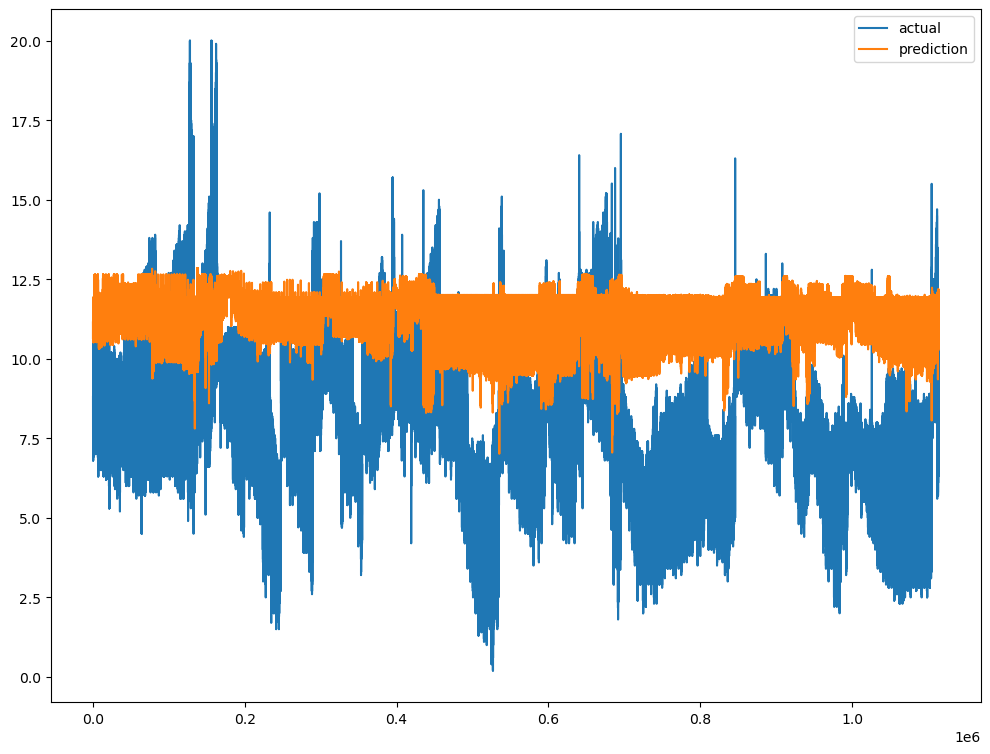

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 9))
plt.plot(y_test, label = 'actual')
plt.plot(pred, label = 'prediction')
plt.legend()
plt.show()
 

[[-0.18433957  0.52774763  1.9009732  ...  0.05673034 -4.1641254
  -0.43665963]
 [ 0.5996102   0.94508773 -0.16962072 ... -0.4439074  -2.2352905
   0.90891796]
 [ 1.9472995  -1.7873453  -2.4376285  ...  1.3752284   2.1589847
  -0.09989979]
 ...
 [ 0.1212548  -0.5385265   0.24444857 ... -0.4172317  -0.09114076
  -0.9657242 ]
 [ 0.62266463 -3.092261   -4.5442295  ...  1.5891901  -4.884716
  -0.32446298]
 [ 0.5805122  -3.2344658  -4.5524225  ...  1.7287967  -4.841956
  -0.3129307 ]]


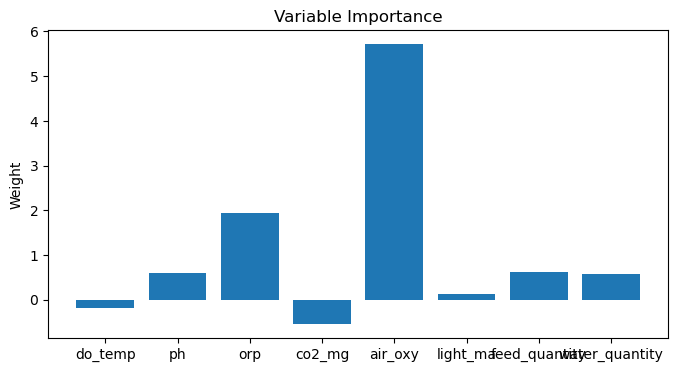

In [17]:
weights = model.layers[0].get_weights()[0]
print(weights)

import matplotlib.pyplot as plt

# 변수 중요도 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(8), weights[:, 0])
ax.set_xticks(range(8))
ax.set_xticklabels(['do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity'])
ax.set_ylabel('Weight')
ax.set_title('Variable Importance')
plt.show()

In [1]:
from keras.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score


# 평가
mse = model.evaluate(x_test, y_test)
mae = model.evaluate(x_test, y_test, metrics=[mean_absolute_error])
r_squared = r2_score(y_test, y_test)


print("MSE: ", mse)
print("MAE: ", mae)
print('R-squared:', r_squared)


NameError: name 'model' is not defined

In [19]:
oneday = validation_oneday[(validation_oneday['mea_dt'].str.contains('2021-07-21'))&(validation_oneday['tank_id']==1)]
#oneday = validation_oneday[(validation.loc[:'2021-08-09 16:3'])&(validation['tank_id']==1)]
oneday = oneday.fillna(0)
x_test_oneday = oneday[['do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
y_test_oneday = oneday[['do_mg']]

x_test_oneday = np.asarray(x_test_oneday, dtype=np.float64)
x_test_oneday = x_test_oneday.reshape((-1, 1, 8))

# shape확인
nCar = x_test_oneday.shape[0] # 데이터 개수
nVar = x_test_oneday.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_oneday.shape[0] # 데이터 개수
nVar = y_test_oneday.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1440 nVar: 1
nCar: 1440 nVar: 1


45/45 [==============================] - 0s 2ms/step


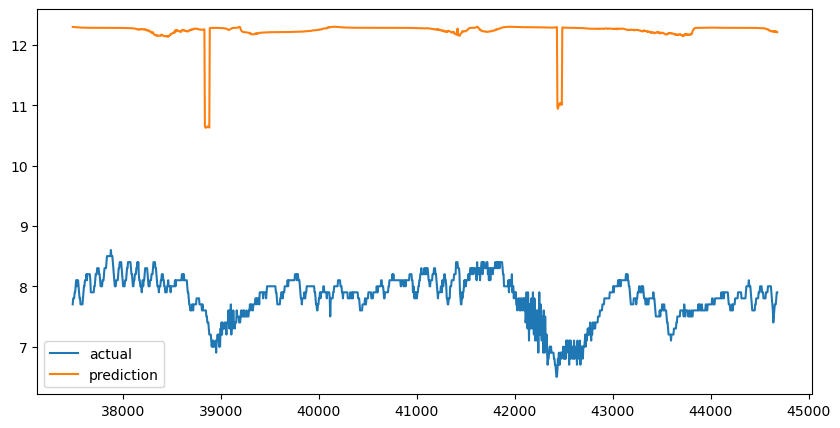

In [20]:
pred_oneday = model.predict(x_test_oneday)
plt.figure(figsize=(10, 5))
plt.plot(oneday.index, y_test_oneday, label = 'actual')
plt.plot(oneday.index, pred_oneday, label = 'prediction')
plt.legend()
plt.show()